In [21]:
import torch
import random
from tqdm import tqdm
from torch import nn, optim
from model import VAE
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from monk import workflow, utils
import pathlib
import signac
import glob
import os
import polars as pl
import numpy as np
import pickle

with open("models/vae-v1-sup.pkl", "rb") as f:
    data = pickle.load(f)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
torch.manual_seed(52)

# Hyperparameters
H_DIM = 400
Z_DIM = 1  # without CNN, or some other specialized encoding, 2 is too small. 20 works well for a simple MLP
ALPHA = 0.1

NUM_EPOCHS = 5
BATCH_SIZE = 128
LR = 3e-4  # Karpathy's constant (totally made up)

# collect data
parent = pathlib.Path(os.getcwd()).parent.parent / "config.yaml"
config = workflow.get_config(parent.as_posix())

project: signac.Project = signac.get_project(root=config["root"])

dfs = []

for job in project:
    print(job)
    prep = job.sp["prep"]

    experiments = sorted(glob.glob(job.fn("longer_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue

    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")

        if (
            float(period) != 1000.0
            or float(temp) != 0.019836
            or float(max_shear) > 0.04
        ):
            continue

        df_paths = glob.glob(job.fn(f"longer_experiments/max-shear-{max_shear}/temp-{temp}/vae-dataset_period-{period}_frame-*.parquet"))

        
        for df_path in df_paths:
            dataset = pl.read_parquet(df_path, use_pyarrow=True)[::10]

            sf_len = dataset[0]["sfs"][0].shape[0]

            X = np.zeros((len(dataset), sf_len + 3 + 1 + 1 + 1), dtype=np.float32)
            X[:, 0] = dataset["strain"]
            X[:, 1] = (dataset["id"] == 0)
            X[:, 2] = (dataset["id"] == 1)
            X[:, 3:-3] = np.vstack(dataset["sfs"].to_numpy())
            X[:, -3] = dataset["frame"]
            X[:, -2] = (prep == "ESL")
            X[:, -1] = dataset["soft"]

            dataset = dataset.with_columns(
                sfs = X,
            )

            dfs.append(dataset)

dataset = pl.concat(dfs)

Y = ((dataset["d2min_left"] > 0.08) | (dataset["d2min_right"] > 0.08)).to_numpy().astype(np.float32)

data_len = len(Y)
sf_len = dataset[0]["sfs"][0].shape[0]

X = np.zeros((data_len, sf_len), dtype=np.float32)
X[:, :] = np.vstack(dataset["sfs"].to_numpy())

# Normalizing Data
scaler: StandardScaler = data["scaler"]
X_scaled = scaler.transform(X)

# scaler_y = StandardScaler()
Y_scaled = Y.reshape(-1, 1)

X_scaled, Y_scaled = shuffle(X_scaled, Y_scaled)

# Converting to PyTorch tensor
X_tensor = torch.FloatTensor(X_scaled)
Y_tensor = torch.FloatTensor(Y_scaled)

import torch.utils.data as data_utils

X_tensor2 = X_tensor.to(device)
Y_tensor2 = Y_tensor.to(device)

torch_dataset = data_utils.TensorDataset(X_tensor2, Y_tensor2)
train_len = int(data_len*0.5)
train, test = data_utils.random_split(torch_dataset, [train_len, data_len - train_len])

train_loader = data_utils.DataLoader(train, batch_size=128, shuffle=True)
test_loader = data_utils.DataLoader(test, batch_size=data_len - train_len)

# Now lets eval!

model = VAE(input_dim=data["input_dim"], h_dim=data["h_dim"], z_dim=data["z_dim"]).to(device)
LOAD_PATH = "models/vae-v1.pth"
model.load_state_dict(torch.load(LOAD_PATH))
loss_fn = nn.BCELoss(reduction="mean")  # y_i * log(x_i) + (1 - y_i) * log(1 - x_i)


for X_test, y_test in test_loader:
    y_pred, mu, sigma = model(X_test)
    recon_loss = loss_fn(y_pred, y_test)
    kl_div = - torch.mean(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

    loss = recon_loss + ALPHA * kl_div
    print(f"loss: {loss.item()}, recon_loss: {recon_loss.item()}, kl_div: {kl_div.item()}")

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
cfa1e4c0007fd65d020f809715a6f0b4
ecce68c50e28a33684826f28780bf6e9
1d0fe2ba44a6f635f5504dcbcee0ebc9
1083a2a09eec2c6cf215ebc7a9706cac
09d3dccc56f1fa9330b57901cd232ab7
6976a7c10ada4159010403f8027f3ea5
9158e73b2e4c9fd1a565e1e5d1bc3af5
c6d7afd0de62bfa16d05da47815227eb
bf92a185d043ce3ef666e05e427c7e76
a8f2c249ed85533b56b0729b7ab96d18
loss: 0.4885428845882416, recon_loss: 0.48854196071624756, kl_div: 9.227511327480897e-06


In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors

In [27]:
inv_trans = scaler.inverse_transform(X_test.detach().numpy())

In [38]:
strain = inv_trans[:, 0]
soft = inv_trans[:, -1]
is_esl = inv_trans[:, -2] == 1
frame = inv_trans[:, -3]

In [29]:
mu, sigma = model.encode(X_test[:, 1:-3])
epsilon = torch.randn_like(sigma)
encoded_data = mu + sigma * epsilon
encoded_data = encoded_data.detach().numpy()

In [30]:
output = model(X_test)[0].cpu().detach().numpy()

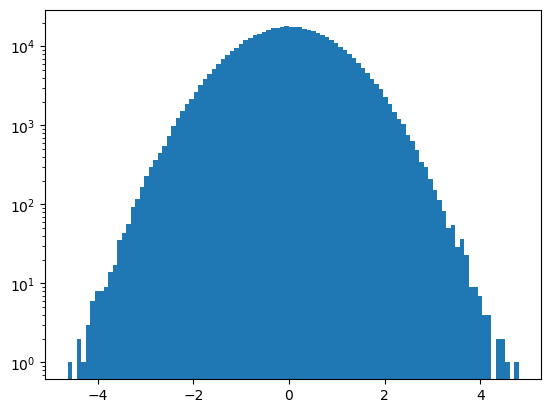

In [34]:
plt.hist(encoded_data, bins=100)
plt.yscale('log');

In [41]:
def logit(x):
    return np.log(x / (1 - x))

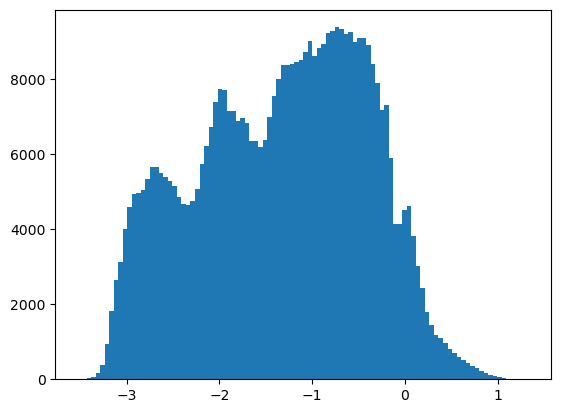

In [42]:
plt.hist(logit(output), bins=100);

In [16]:
import seaborn as sns
import pandas as pd

In [51]:
np.isclose(strain, 0.01)

array([False, False, False, ...,  True, False, False])

(array([1.000e+00, 2.000e+00, 2.000e+00, 8.000e+00, 1.600e+01, 1.800e+01,
        3.600e+01, 6.300e+01, 8.600e+01, 1.240e+02, 1.590e+02, 2.030e+02,
        2.740e+02, 3.330e+02, 4.160e+02, 5.310e+02, 5.570e+02, 6.300e+02,
        8.140e+02, 8.480e+02, 9.020e+02, 9.270e+02, 9.830e+02, 9.800e+02,
        1.094e+03, 1.115e+03, 1.085e+03, 1.168e+03, 1.303e+03, 1.312e+03,
        1.342e+03, 1.441e+03, 1.471e+03, 1.548e+03, 1.550e+03, 1.536e+03,
        1.568e+03, 1.515e+03, 1.462e+03, 1.456e+03, 1.454e+03, 1.474e+03,
        1.471e+03, 1.597e+03, 1.565e+03, 1.311e+03, 8.170e+02, 7.660e+02,
        7.730e+02, 7.490e+02, 8.120e+02, 8.530e+02, 9.720e+02, 1.004e+03,
        1.010e+03, 1.002e+03, 8.920e+02, 8.270e+02, 7.560e+02, 7.260e+02,
        6.300e+02, 5.180e+02, 5.340e+02, 4.330e+02, 4.710e+02, 3.880e+02,
        3.640e+02, 3.300e+02, 3.390e+02, 3.150e+02, 2.730e+02, 2.870e+02,
        2.610e+02, 2.470e+02, 2.360e+02, 1.930e+02, 2.000e+02, 1.810e+02,
        1.600e+02, 1.590e+02, 1.440e+0

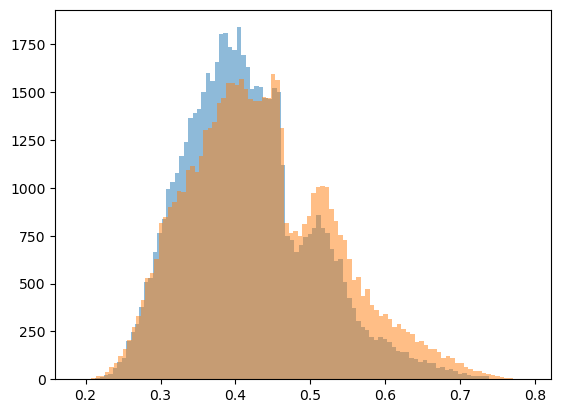

In [62]:
tout = output[np.isclose(strain, 0.04) & is_esl]
plt.hist(tout, bins=100, alpha=0.5)
tout = output[np.isclose(strain, 0.04) & ~is_esl]
plt.hist(tout, bins=100, alpha=0.5)

/tmp/ipykernel_77975/2789648097.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for c, ldf in tdf.groupby("cut"):
/tmp/ipykernel_77975/2789648097.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for c, ldf in tdf.groupby("cut"):


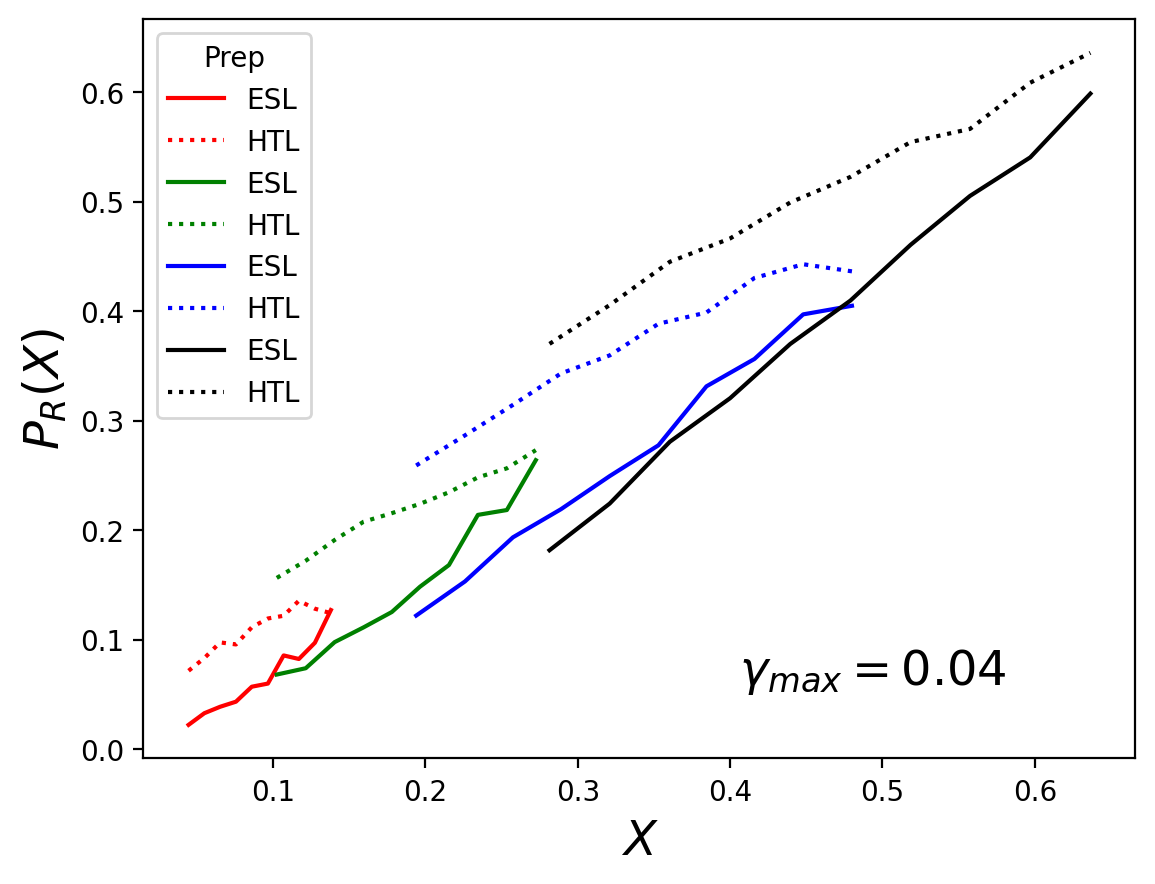

In [61]:
plt.figure(dpi=200)

unique_strains = np.unique(strain)

for unique_strain, color in zip(unique_strains, ["r", "g", "b", "k"]):
    idx = strain == unique_strain
    # cut_bins = np.linspace(0.1, 0.8, 9)
    output_ = output.reshape(-1)[is_esl & idx]
    bounds = np.quantile(output_, [0.01, 0.99])
    # bounds = [0, 1]
    cut_bins = np.linspace(bounds[0], bounds[1], 11)
    X_cuts =  pd.cut(output_, cut_bins)
    pr = y_test.cpu().detach().numpy().reshape(-1)[is_esl & idx]

    tdf = pd.DataFrame({"output": output_, "cut": X_cuts, "pr": pr})
    x = []
    y = []
    for c, ldf in tdf.groupby("cut"):
        x.append(c.mid)
        y.append(ldf["pr"].mean())

    plt.plot(x, y, "-", color=color, label="ESL")

    output_ = output.reshape(-1)[~is_esl & idx]
    # bounds = np.quantile(output_, [0.01, 0.99])
    cut_bins = np.linspace(bounds[0], bounds[1], 11)
    X_cuts =  pd.cut(output_, cut_bins)
    pr = y_test.cpu().detach().numpy().reshape(-1)[~is_esl & idx]

    tdf = pd.DataFrame({"output": output_, "cut": X_cuts, "pr": pr})
    x = []
    y = []
    for c, ldf in tdf.groupby("cut"):
        x.append(c.mid)
        y.append(ldf["pr"].mean())

    plt.plot(x, y, ":", color=color, label="HTL")
    # break

plt.xlabel(r"$X$", size="xx-large")
plt.ylabel(r"$P_R(X)$", size="xx-large")
plt.legend(title="Prep")
plt.text(0.6, 0.1, r"$\gamma_{max}=0.04$", transform=plt.gca().transAxes, size="xx-large")
plt.savefig("pr.png")